In [ ]:
import pandas as pd

df = pd.read_csv('../data/csv/data.csv')

print(df.shape)
df.head()

(1254243, 6)


,CLNT_RMT_IP,ROI_CLICK_EVENT_TS,BRWSR_NAME,ams_pblshr_id,buyer_id,click_id
0,77.111.247.168,2020-08-02 18:37:01,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,valen_949,209245484389035777
1,66.249.73.101,2020-08-21 03:36:38,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586
2,77.111.247.129,2020-08-21 03:36:38,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586
3,66.249.73.101,2020-08-21 03:36:33,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586
4,77.111.247.129,2020-08-21 03:36:33,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586


In [ ]:
# Calculate time difference between clicks
df['ROI_CLICK_EVENT_TS'] = pd.to_datetime(df['ROI_CLICK_EVENT_TS'])
df = df.sort_values(['buyer_id', 'ROI_CLICK_EVENT_TS'])
df['time_diff'] = df.groupby('buyer_id')['ROI_CLICK_EVENT_TS'].diff().dt.total_seconds().fillna(0)


In [ ]:
# Count clicks in 1-minute windows
df['minute'] = df['ROI_CLICK_EVENT_TS'].dt.floor('T')
click_counts = df.groupby(['buyer_id', 'minute']).size().reset_index(name='clicks_per_minute')


C:\Users\Rajneesh\AppData\Local\Temp\ipykernel_20920\1643154947.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['ROI_CLICK_EVENT_TS'].dt.floor('T')


In [ ]:
from hmmlearn import hmm
import numpy as np

# Preparing time gap data for HMM
time_gaps = df.groupby('buyer_id')['time_diff'].apply(list).values
flat_gaps = np.concatenate(time_gaps).reshape(-1, 1)

# Train a 2-component Gaussian HMM
hmm_model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=100, random_state=42)
hmm_model.fit(flat_gaps)

# Predicting the hidden states
hidden_states = hmm_model.predict(flat_gaps)
df['hmm_state'] = np.concatenate([np.repeat(state, len(seq)) for state, seq in zip(hidden_states, time_gaps)])
print(df.head())


            CLNT_RMT_IP  ROI_CLICK_EVENT_TS  \
481168  172.225.184.187 2022-09-28 09:00:05   
957065     172.225.6.64 2024-09-19 10:20:24   
586981  195.181.174.227 2022-05-22 15:57:24   
586982  195.181.174.227 2022-05-22 16:02:30   
586983  195.181.174.227 2022-05-22 16:26:13   

                                               BRWSR_NAME  ams_pblshr_id  \
481168  Mozilla/5.0 (iPhone; CPU iPhone OS 16_0_2 like...     5575403800   
957065  Mozilla/5.0 (iPhone; CPU iPhone OS 18_0 like M...     5574635388   
586981  ebayUserAgent/eBayIOS;6.60.0;iOS;15.4.1;Apple;...     5575532731   
586982  ebayUserAgent/eBayIOS;6.60.0;iOS;15.4.1;Apple;...     5575532731   
586983  ebayUserAgent/eBayIOS;6.60.0;iOS;15.4.1;Apple;...     5575532731   

             buyer_id            click_id  time_diff              minute  \
481168     !!!eule!!!  218153671260927361        0.0 2022-09-28 09:00:00   
957065  !!!scheela!!!  226330661662892416        0.0 2024-09-19 10:20:00   
586981        !!mat!!  216694068

In [12]:
# # Predict log likelihood for sequences
# log_likelihood = hmm_model.score_samples(flat_gaps)
# df['log_likelihood'] = log_likelihood

# # Mark anomalies where log likelihood is below a threshold
# threshold = np.percentile(log_likelihood, 10)  # 10% lowest log likelihood as anomalies
# df['anomaly'] = df['log_likelihood'] < threshold
# print(df[df['anomaly']])
# Initialize an empty list for storing log-likelihood values
log_likelihoods = []

# Loop over each buyer's click sequence
for time_gap_sequence in df.groupby('buyer_id')['time_diff']:
    log_likelihood = hmm_model.score(np.array(time_gap_sequence[1]).reshape(-1, 1))
    log_likelihoods.extend([log_likelihood] * len(time_gap_sequence[1]))  # Assign to each row in sequence

# Assign log-likelihoods back to the DataFrame
df['log_likelihood'] = log_likelihoods


In [38]:
# Define anomaly threshold
threshold = np.percentile(df['log_likelihood'], 8)  # Lowest 10% log-likelihood values are anomalies

# Mark anomalies in the DataFrame
df['anomaly'] = df['log_likelihood'] < threshold
print(df[df['anomaly']].head())


           CLNT_RMT_IP  ROI_CLICK_EVENT_TS  \
29480   77.111.247.146 2020-09-01 08:52:47   
533715  77.111.247.168 2020-09-02 04:00:03   
970175  77.111.247.168 2020-09-02 04:55:48   
970174  77.111.247.168 2020-09-02 04:55:52   
191034  77.111.247.119 2020-09-08 02:13:11   

                                               BRWSR_NAME  ams_pblshr_id  \
29480   Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...     5574630565   
533715  Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...     5574630565   
970175  Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...     5574630565   
970174  Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...     5574630565   
191034  Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...     5574672411   

        buyer_id            click_id  time_diff              minute  \
29480   12stamps  209580894230993793        0.0 2020-09-01 08:52:00   
533715  12stamps  209589943662790657    68836.0 2020-09-02 04:00:00   
970175  12stamps  209590327332652417     3345.0 2020-

d:\vpn_annotator\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


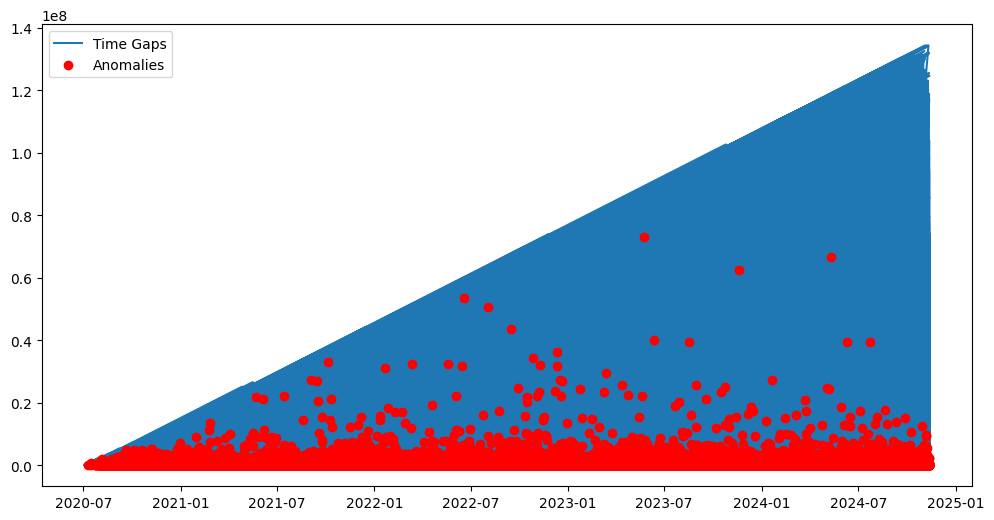

In [39]:


import matplotlib.pyplot as plt

# Plotting time gaps and anomalies
plt.figure(figsize=(12, 6))
plt.plot(df['ROI_CLICK_EVENT_TS'], df['time_diff'], label='Time Gaps')
plt.scatter(df[df['anomaly']]['ROI_CLICK_EVENT_TS'], df[df['anomaly']]['time_diff'], color='red', label='Anomalies', zorder=5)
plt.legend()
plt.show()


In [30]:
df['anomaly'].nunique()

2

In [31]:
anomalous_rows = df[df['anomaly']]

# Show the first few anomalous rows
print(anomalous_rows.head())


           CLNT_RMT_IP  ROI_CLICK_EVENT_TS  \
1158645  155.94.160.29 2023-08-15 10:32:25   
1158651  155.94.160.29 2023-08-15 10:33:41   
1158650  155.94.160.29 2023-08-15 10:37:28   
1158648  155.94.160.29 2023-08-15 10:37:29   
1158652  155.94.160.29 2023-08-15 10:39:52   

                                                BRWSR_NAME  ams_pblshr_id  \
1158645  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     5575082068   
1158651  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     5575082068   
1158650  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     5575082068   
1158648  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     5575082068   
1158652  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     5575082068   

          buyer_id            click_id  time_diff              minute  \
1158645  ndeals100  221789612622365696        0.0 2023-08-15 10:32:00   
1158651  ndeals100  221789612622365696       76.0 2023-08-15 10:33:00   
1158650  ndeals100  221789612622365696   

In [32]:
anomalous_rows.shape

(36505, 11)

In [33]:
non_anomalous_rows = df[~df['anomaly']]

# Show the first few anomalous rows
print(non_anomalous_rows.head())


            CLNT_RMT_IP  ROI_CLICK_EVENT_TS  \
481168  172.225.184.187 2022-09-28 09:00:05   
957065     172.225.6.64 2024-09-19 10:20:24   
586981  195.181.174.227 2022-05-22 15:57:24   
586982  195.181.174.227 2022-05-22 16:02:30   
586983  195.181.174.227 2022-05-22 16:26:13   

                                               BRWSR_NAME  ams_pblshr_id  \
481168  Mozilla/5.0 (iPhone; CPU iPhone OS 16_0_2 like...     5575403800   
957065  Mozilla/5.0 (iPhone; CPU iPhone OS 18_0 like M...     5574635388   
586981  ebayUserAgent/eBayIOS;6.60.0;iOS;15.4.1;Apple;...     5575532731   
586982  ebayUserAgent/eBayIOS;6.60.0;iOS;15.4.1;Apple;...     5575532731   
586983  ebayUserAgent/eBayIOS;6.60.0;iOS;15.4.1;Apple;...     5575532731   

             buyer_id            click_id  time_diff              minute  \
481168     !!!eule!!!  218153671260927361        0.0 2022-09-28 09:00:00   
957065  !!!scheela!!!  226330661662892416        0.0 2024-09-19 10:20:00   
586981        !!mat!!  216694068

In [34]:
non_anomalous_rows.shape

(1217738, 11)

In [35]:
non_anomalous_rows['buyer_id'].value_counts()

buyer_id
alphaseeker    3224
yangbangban    2805
social_lite    2794
kennyb-0       2657
lostandlost    2360
               ... 
zzr600d3          1
zzr611            1
zzrd411           1
zzrwolfi          1
zzseller          1
Name: count, Length: 465394, dtype: int64

In [24]:
anomalous_rows['buyer_id'].value_counts()

buyer_id
ndeals80          8220
timhu_11          7102
ndeals60          6489
supenko2          5622
ndeals90          4889
                  ... 
keepitcrazy         94
stit6509            94
headbodyhead        94
wentwelltheday      94
harham_8189         93
Name: count, Length: 416, dtype: int64

In [37]:
df.to_csv('../data/csv/anamoly_click_pattern/anamoly_data.csv')

In [27]:
df.shape

(1254243, 11)